# Learning about spatial data and maps for archaeology (and other things)

### Spatial Thinking and Skills Exercise 1 for Theory and Practice

#### Made by Rachel Opitz, Archaeology, University of Glasgow



Archaeologists regularly work with maps and data about where sites, samples and objects are found. Archaeological survey in particular relies on the collection and analysis of spatial data to understand patterns across whole areas of the landscape. Are most sites in a given landscape from a particular period? Are there more cairns than anything else? Are sites from all periods represented equally? These are the kinds of questions one might as using survey data. 


The aim of this exercise is for you to:
* learn to investigate patterns in archaeological survey data using spatial analytical tools
* learn to learn to make maps that illustrate patterns in archaeological survey data
* start thinking about the meaning of the patterns of sites and features in the landscape

You'll do this using data available from Canmore that describes the location and type of monuments surveyed throughout the Shetlands. Canmore houses survey data on sites and monuments recorded throughout Scotland.

As you may recall from Archaeology of Scotland, to start working with spatial data and maps, you need to put together your toolkit. You're currently working inside something called a jupyter notebook. It's a place to keep notes, pictures, code and maps together. You can add tools and data into your jupyter notebook and then use them to ask spatial questions and make maps and visualisations that help answer those questions. 


### Let's get started... Hit 'Ctrl'+'Enter' to run the code in any cell in the page.

[Canmore spatial data can be found here.](https://canmore.org.uk/content/data-downloads)

### We'll start by adding some of the tools we will need. They're not quite like these tools...

![They're not quite like these tools...](http://www.truelles-pixels.mom.fr/english/episode01/knowmore_files/outils.jpg)

In [150]:
%matplotlib inline
# Matplotlib is your tool for drawing graphs and basic maps. You need this!

import pandas as pd
import requests
import fiona
import geopandas as gpd
import pysal as ps
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import cluster
from sklearn.preprocessing import scale
sns.set_style("white")
from shapely.ops import nearest_points

# These are what we call prerequisites. They are basic toosl you need to get started.
# Pandas manipulate data. Geo-pandas manipulate geographic data. They're also black and white and like to eat bamboo... 
# You need these to manipulate your data!
# Fiona helps with geographic data.
# Requests are for asking for things. It's good to be able to ask for things.
# ipywidgets supports interactivity.


# Remember to hit Ctrl+Enter to make things happen!

### Now that we have the basic tools loaded up we need to load the Canmore data. Canmore provides polygons showing the site extents. I've converted them to a set of points located at the centre of each polygon to make things a little simpler in this exercise.

In [3]:
url = 'http://ropitz.github.io/digitalantiquity/data/CanmoreShetlandPoints.geojson'
# This is where I put the data. It's in a format called geojson, used to represent geometry (shapes) and attributes (text).
request = requests.get(url)
# Please get me the data at that web address (url)
b = bytes(request.content)
# I will use the letter 'b' to refer to the data, like a nickname
with fiona.BytesCollection(b) as f:
    crs = f.crs
    canmore_shetland = gpd.GeoDataFrame.from_features(f, crs=crs)
    print(canmore_shetland.head())
# I will use the fiona tool to wrap up all the data from 'b', check the coordinate system (crs) listed in the features
# and print out the first few lines of the file so I can check everything looks ok. 
# Don't worry if you don't understand all the details of this part!



                                               CLASS  \
0                        AGRICULTURE AND SUBSISTENCE   
1                       MONUMENT (BY FORM), DOMESTIC   
2                        AGRICULTURE AND SUBSISTENCE   
3  AGRICULTURE AND SUBSISTENCE, MONUMENT (BY FORM...   
4                       MONUMENT (BY FORM), DOMESTIC   

                                  INFO                                 LINK  \
0  Archaeology: Shetland Amenity Trust  https://canmore.org.uk/site/307620/   
1  Archaeology: Shetland Amenity Trust     https://canmore.org.uk/site/718/   
2  Archaeology: Shetland Amenity Trust  https://canmore.org.uk/site/308223/   
3  Archaeology: Shetland Amenity Trust  https://canmore.org.uk/site/333500/   
4  Archaeology: Shetland Amenity Trust     https://canmore.org.uk/site/305/   

  NOTES  OBJECTID           POLYCLAS   POLYTYPE  \
0           91225  KNOWN SITE EXTENT       FORM   
1           91306     DISCOVERY AREA  DISCOVERY   
2           92937  KNOWN SITE EXTEN

### Does that look right? 

You should see descriptions of different types of monuments and notes on them and links to the original data on Canmore. Get help if this isn't what you are seeing.

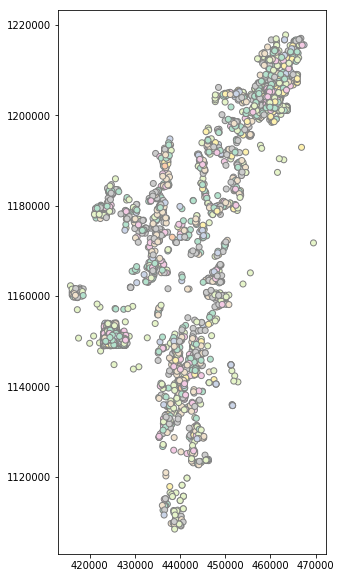

In [4]:
# Let's visualise the data to double check that all is well

canmore_shetland_map = canmore_shetland.plot(column='CLASS', cmap='Pastel2', edgecolor='grey', figsize=(10, 10));
# 'plot' means draw me an image showing the geometry of each feature in my data. 
# We want to control things like the color of different types of sites on our map. 
# I used the pastel colorscale command (cmap stands for 'colour map') 
# and asked it to draw the points differently based on the type they were assigned.

### Everything good?

If you see a bunch of pastel dots, you are on the right track.Once the data is loaded properly, we can start exploring it and seeing if there are patterns within this national survey dataset. 

Let's start by printing out the attributes of our points as a table. You'll be exploring the data based on it's attributes, so it is important to have a sense of what they are. Scroll down and start to ask yourself some basic questions. What are the feature types assigned in this dataset? Do they mostly have periods assigned to them?

In [5]:
canmore_shetland

,CLASS,INFO,LINK,NOTES,OBJECTID,POLYCLAS,POLYTYPE,SOURCE,STATUS,TYPE,X,Y,geometry
0,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/307620/,,91225,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,PEN (PERIOD UNASSIGNED),423277.0,1148999.0,POINT (423277.2439290185 1148999.3494361)
1,"MONUMENT (BY FORM), DOMESTIC",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/718/,,91306,DISCOVERY AREA,DISCOVERY,"OS 6"" 1st Ed: 1843-1882 (raster)",Area of historic environment interest: This ar...,BROCH (IRON AGE)(POSSIBLE),430890.0,1144320.0,POINT (430890.1232999999 1144320.4995)
2,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/308223/,,92937,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,"PLANTICRUB (PERIOD UNASSIGNED), SHEEP SHELTER ...",424681.0,1150587.0,POINT (424680.8703317239 1150587.032565489)
3,"AGRICULTURE AND SUBSISTENCE, MONUMENT (BY FORM...",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/333500/,,92965,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,"FIELD BOUNDARY(S) (PREHISTORIC), ROUNDHOUSE (P...",459340.0,1202964.0,POINT (459343.241000996 1202968.882597374)
4,"MONUMENT (BY FORM), DOMESTIC",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/305/,,92971,DISCOVERY AREA,DISCOVERY,"OS 6"" 1st Ed: 1843-1882 (raster)",Area of historic environment interest: This ar...,BROCH (IRON AGE),422420.0,1147800.0,POINT (422426.0928188833 1147812.774734864)
5,"AGRICULTURE AND SUBSISTENCE, MONUMENT (BY FORM)",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/311601/,,92976,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,"ENCLOSURE (PERIOD UNASSIGNED), PLANTICRUB (PER...",427556.0,1150931.0,POINT (427556.2153704547 1150931.546566914)
6,DEFENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/348987/,,92977,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Area of historic environment interest: This ar...,OBSERVATION POST (FIRST WORLD WAR),432049.0,1164719.0,POINT (432049.9275158309 1164719.759336468)
7,"AGRICULTURE AND SUBSISTENCE, DOMESTIC",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/312450/,,93004,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,"HUT (PERIOD UNASSIGNED)(POSSIBLE), PEN (PERIOD...",427479.0,1149963.0,POINT (427479.6074284117 1149963.9358313)
8,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/332007/,,93028,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,PEN(S) (PERIOD UNASSIGNED),424316.0,1152285.0,POINT (424317.2590276005 1152286.429604599)
9,"UNASSIGNED, MONUMENT (BY FORM)",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/189462/,,93043,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Area of historic environment interest: This ar...,BUILDING (PERIOD UNASSIGNED),444250.0,1152240.0,POINT (444189.3770378756 1152289.788488856)


Hmmm... If you're me at this point you are a bit concerned about all the sites with a 'PERIOD UNASSIGNED' note. Let's try and see how much of our dataset is actually dated in some way.

In [15]:
#How many features do we have in total. Let's count them.
canmore_shetland.count()

CLASS       4148
INFO        4148
LINK        4148
NOTES       4148
OBJECTID    4148
POLYCLAS    4148
POLYTYPE    4148
SOURCE      4148
STATUS      4148
TYPE        4148
X           4148
Y           4148
geometry    4148
dtype: int64

In [37]:
# Now let's count the ones that have 'PERIOD UNASSIGNED' as part of the 'TYPE' field.

canmore_shetland_undated = canmore_shetland[canmore_shetland['TYPE'].str.contains('PERIOD UNASSIGNED')]
canmore_shetland_undated.count()

CLASS       3451
INFO        3451
LINK        3451
NOTES       3451
OBJECTID    3451
POLYCLAS    3451
POLYTYPE    3451
SOURCE      3451
STATUS      3451
TYPE        3451
X           3451
Y           3451
geometry    3451
dtype: int64

In [19]:
# Hmmm... quite a few. Almost 85% of the data! I have questions... 
# Let's look at the distribution of the points that do have dates. The ~ symbol means 'opposite of'.

canmore_shetland_dated = canmore_shetland[~canmore_shetland['TYPE'].str.contains('PERIOD UNASSIGNED')]
canmore_shetland_dated

,CLASS,INFO,LINK,NOTES,OBJECTID,POLYCLAS,POLYTYPE,SOURCE,STATUS,TYPE,X,Y,geometry
1,"MONUMENT (BY FORM), DOMESTIC",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/718/,,91306,DISCOVERY AREA,DISCOVERY,"OS 6"" 1st Ed: 1843-1882 (raster)",Area of historic environment interest: This ar...,BROCH (IRON AGE)(POSSIBLE),430890.0,1144320.0,POINT (430890.1232999999 1144320.4995)
3,"AGRICULTURE AND SUBSISTENCE, MONUMENT (BY FORM...",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/333500/,,92965,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,"FIELD BOUNDARY(S) (PREHISTORIC), ROUNDHOUSE (P...",459340.0,1202964.0,POINT (459343.241000996 1202968.882597374)
4,"MONUMENT (BY FORM), DOMESTIC",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/305/,,92971,DISCOVERY AREA,DISCOVERY,"OS 6"" 1st Ed: 1843-1882 (raster)",Area of historic environment interest: This ar...,BROCH (IRON AGE),422420.0,1147800.0,POINT (422426.0928188833 1147812.774734864)
6,DEFENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/348987/,,92977,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Area of historic environment interest: This ar...,OBSERVATION POST (FIRST WORLD WAR),432049.0,1164719.0,POINT (432049.9275158309 1164719.759336468)
17,DEFENCE,Historic Environment Scotland | Àrainneachd Ea...,https://canmore.org.uk/site/72079/,First World War coast battery.,93128,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Some or all of this area is a Scheduled Monument,COASTAL BATTERY (FIRST WORLD WAR),428984.0,1161941.0,POINT (429066.2493318138 1161901.638222312)
18,MONUMENT (BY FORM),Historic Environment Scotland | Àrainneachd Ea...,https://canmore.org.uk/site/331808/,,93134,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Some or all of this area is a Scheduled Monument,CAIRN (PREHISTORIC),424571.0,1152455.0,POINT (424570.7363696579 1152455.52502646)
19,"AGRICULTURE AND SUBSISTENCE, MONUMENT (BY FORM...",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/108170/,,93146,DISCOVERY AREA,DISCOVERY,RCAHMS 10K record sheets (raster),Area of historic environment interest: This ar...,"MIDDEN (IRON AGE), ROUNDHOUSE (IRON AGE)",458100.0,1207400.0,POINT (458100.0000000005 1207400.000000001)
40,"MONUMENT (BY FORM), DOMESTIC",Historic Environment Scotland | Àrainneachd Ea...,https://canmore.org.uk/site/1288/,http://data.historic-scotland.gov.uk/pls/htmld...,93368,DISCOVERY AREA,DISCOVERY,25cm Orthorectified AP (raster),Some or all of this area is a Scheduled Monument,BROCH (IRON AGE),452100.0,1142310.0,POINT (452103.0696655144 1142311.717053322)
41,"MONUMENT (BY FORM), DOMESTIC",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/315774/,,93369,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Area of historic environment interest: This ar...,COTTAGE (20TH CENTURY),436810.0,1131011.0,POINT (436813.2390818477 1131010.101687767)
43,"MONUMENT (BY FORM), DOMESTIC",Historic Environment Scotland | Àrainneachd Ea...,https://canmore.org.uk/site/88/,,93401,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Some or all of this area is a Scheduled Monument,BROCH (IRON AGE),466000.0,1208950.0,POINT (466002.0737538508 1208950.785918241)


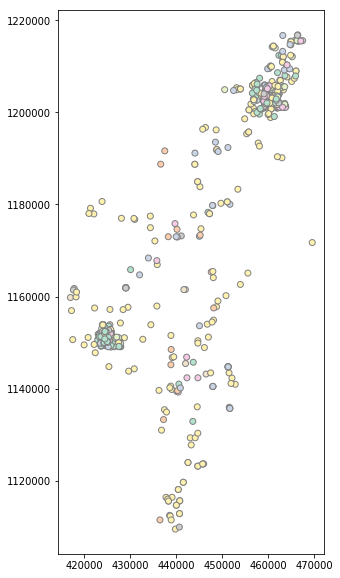

In [39]:
canmore_shetland_dated.plot(column='CLASS', cmap='Pastel2', edgecolor='grey', figsize=(10, 10));

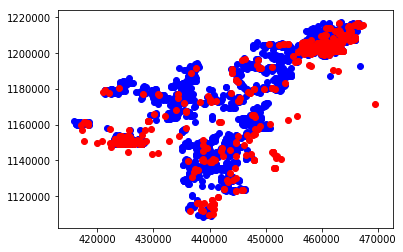

In [40]:
# Well, there are still some sites everywhere. Compare visually with the earlier map... 
# Make the dated sites red and undated sites blue

fig, ax = plt.subplots()
canmore_shetland_undated.plot(ax=ax, color='blue',)
canmore_shetland_dated.plot(ax=ax, color='red')
plt.show();

Do you think the dated sites are representing the whole dataset well? If yes, you might feelc omfortable working with only the dated sites. If not, you might want to continue to work with all the sites. 

What are the implications of this choice?

I'm going to start by exploring only the dated sites and then compare the results with all the sites. I've noticed there are site from 'prehistory' and 'norse' periods. I'm wondering if in general preservation is better in some parts of the Shetlands, and so we will find most of the concentrations of these older sites in one area. To explore this question, I'm going to use something called a 'kde plot'. KDE plots show areas where things concentrate or cluster together. 

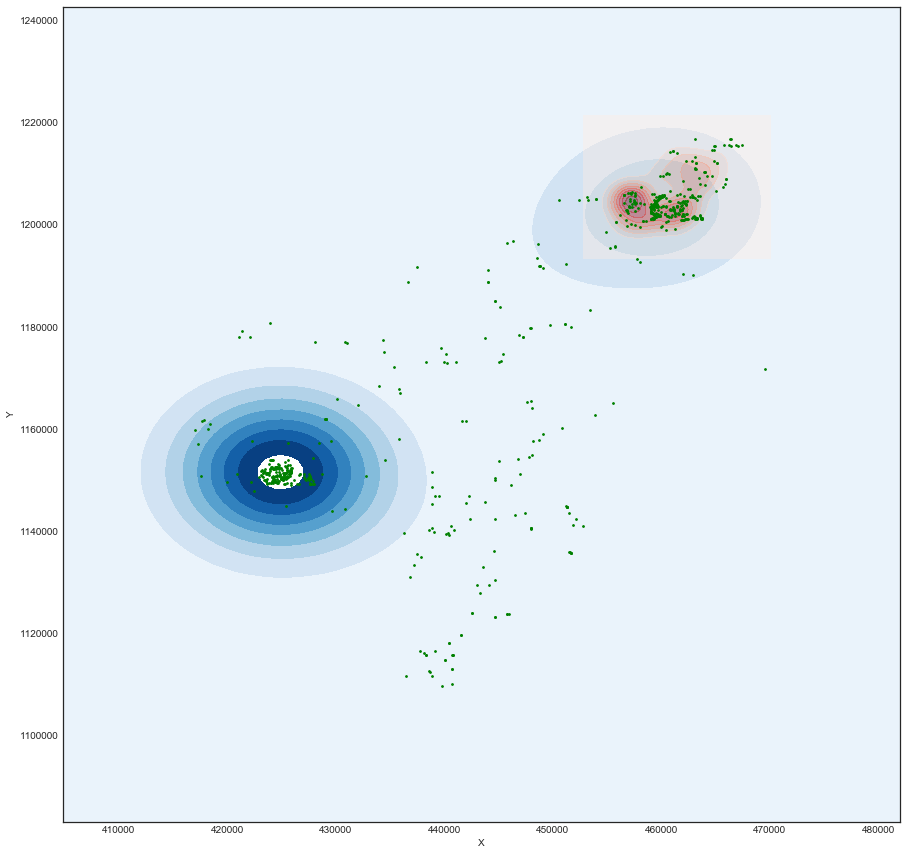

In [96]:

canmore_shetland_prehistory = canmore_shetland[canmore_shetland['TYPE'].str.contains('PREHISTORIC')]
canmore_shetland_norse = canmore_shetland[canmore_shetland['TYPE'].str.contains('NORSE')]

# prehistoric sites will be in blue
fig, ax = plt.subplots(figsize=(15,15))

sns.kdeplot(canmore_shetland_prehistory['X'], canmore_shetland_prehistory['Y'], shade=True, cmap='Blues');

# Norse sites will be in red
sns.kdeplot(canmore_shetland_norse['X'], canmore_shetland_norse['Y'], shade=True, cmap='Reds', alpha=0.4);

#All the dated sites will appear as green dots, so we can see where the clusters are within the whole set of sites.
canmore_shetland_dated.plot(ax=ax, color='Green',markersize=3)
plt.show();




What do you see? Tp me there seem to be two clusters of prehistoric sites.
The norse sites seem to match with the more northern of those clusters.

Now let's look at the pattern for 19th-20th c. sites. Looking at the table, all these sites have the word 'century' in their period description and nothing else seems to match this pattern.

In [114]:
#sanity check yourself...
canmore_shetland_modern = canmore_shetland_dated[canmore_shetland_dated['TYPE'].str.contains('CENTURY')]
canmore_shetland_modern



,CLASS,INFO,LINK,NOTES,OBJECTID,POLYCLAS,POLYTYPE,SOURCE,STATUS,TYPE,X,Y,geometry
41,"MONUMENT (BY FORM), DOMESTIC",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/315774/,,93369,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Area of historic environment interest: This ar...,COTTAGE (20TH CENTURY),436810.0,1131011.0,POINT (436813.2390818477 1131010.101687767)
48,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/340693/,,93477,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,PLANTICRUB (19-20TH CENTURY),463242.0,1201099.0,POINT (463240.1049000006 1201100.106950002)
86,INDUSTRIAL,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/340769/,,93929,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,GRAVEL PIT (19-20TH CENTURY),459651.0,1201694.0,POINT (459651.4131318614 1201692.900009689)
98,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/307776/,,94029,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,KALE YARD (19-20TH CENTURY),424141.0,1149800.0,POINT (424141.2911556137 1149800.714878862)
106,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/313906/,,94085,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,KALE YARD (19-20TH CENTURY),425835.0,1151545.0,POINT (425836.846793975 1151545.325289824)
119,INDUSTRIAL,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/331838/,,94198,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,GRAVEL PIT (19-20TH CENTURY),425227.0,1150307.0,POINT (425227.1947243102 1150306.58061716)
137,"UNASSIGNED, MONUMENT (BY FORM)",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/333002/,,94403,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,BUILDING (19-20TH CENTURY),461755.0,1202970.0,POINT (461756.5302500002 1202971.93195)
159,INDUSTRIAL,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/340531/,,94632,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,GRAVEL PIT (19-20TH CENTURY),459034.0,1202586.0,POINT (459029.8746932997 1202589.59000029)
170,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/308138/,,94753,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,KALE YARD (19-20TH CENTURY),424319.0,1150515.0,POINT (424319.1820550353 1150516.154704023)
188,INDUSTRIAL,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/334250/,,94889,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,GRAVEL PIT (19-20TH CENTURY),459348.0,1204103.0,POINT (459347.2260062199 1204105.636447565)


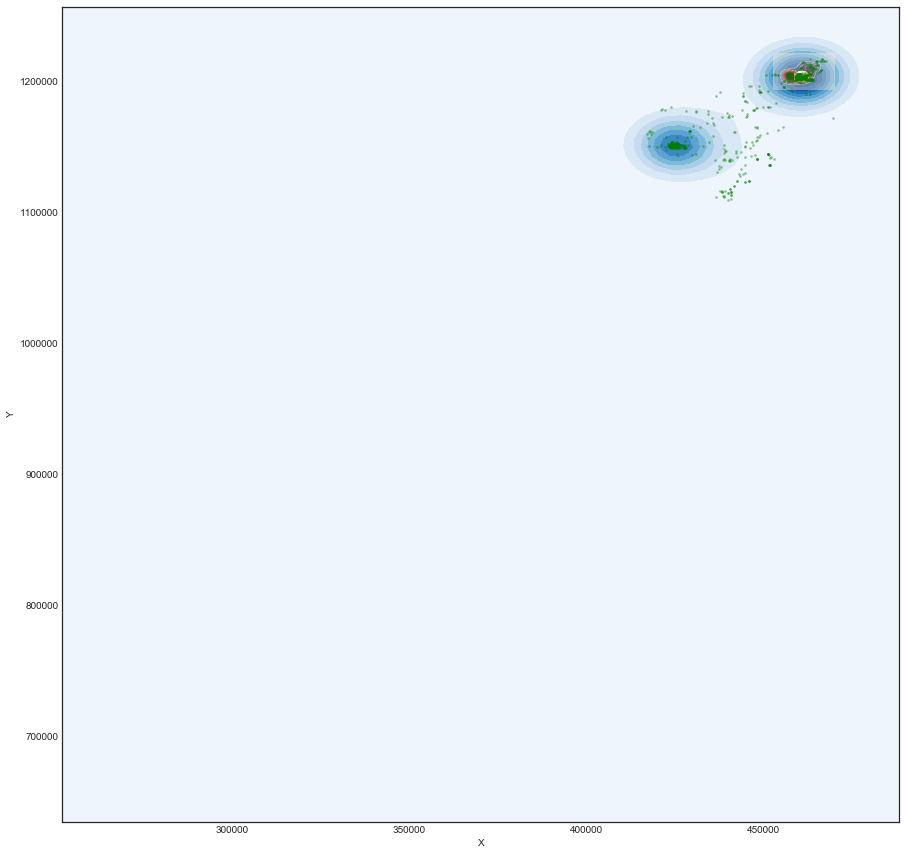

In [109]:
#and make a map

fig, ax = plt.subplots(figsize=(15,15))

#modern site clusters will be in blue
sns.kdeplot(canmore_shetland_modern['X'], canmore_shetland_modern['Y'], shade=True, cmap='Blues');

#All the dated sites will appear as green dots, so we can see where the clusters are within the whole set of sites.
canmore_shetland_dated.plot(ax=ax, color='Green',markersize=3, alpha =0.3)
plt.show();



Hmm. Our map appears to be squished up into the top right corner. What could be happening? I suggest we have a few points in our data that are not actually in the Shetlands or otherwise have dodgy coordinates. Let's investigate by sorting by the X coordinate.

In [115]:
canmore_shetland_modern.sort_values('X')

,CLASS,INFO,LINK,NOTES,OBJECTID,POLYCLAS,POLYTYPE,SOURCE,STATUS,TYPE,X,Y,geometry
574,DEFENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/332552/,,99342,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,"DRILL HALL (FIRST WORLD WAR), DRILL HALL (19-2...",273466.0,904006.0,POINT (423877.6726622845 1151293.721354214)
3229,"MONUMENT (BY FORM), DOMESTIC",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/138130/,,127836,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,TERRACED HOUSE (19TH CENTURY),325237.0,674328.0,POINT (424134.9806230934 1150587.541263468)
1684,TRANSPORT,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/132577/,,111621,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Area of historic environment interest: This ar...,AIRFIELD (20TH CENTURY),417050.0,1159800.0,POINT (417036.9319500003 1159796.836900002)
1275,"UNASSIGNED, MONUMENT (BY FORM), AGRICULTURE AN...",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/340986/,,107029,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Area of historic environment interest: This ar...,"BUILDING (19-20TH CENTURY), SHEEPFOLD(S) (19-2...",417700.0,1161430.0,POINT (417682.637097418 1161440.580730184)
514,"UNASSIGNED, MONUMENT (BY FORM), AGRICULTURE AN...",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/340986/,,98587,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Area of historic environment interest: This ar...,"BUILDING (19-20TH CENTURY), SHEEPFOLD(S) (19-2...",417700.0,1161430.0,POINT (417865.7666301367 1161758.487139103)
2325,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/190420/,,117771,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,"FIELD SYSTEM (NEOL/BRONZE AGE), PLANTICRUB (19...",422960.0,1150530.0,POINT (422958.1936200456 1150529.845807465)
3486,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/308539/,,130517,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,KALE YARD (19-20TH CENTURY),423322.0,1151282.0,POINT (423323.252908628 1151282.401955724)
603,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/190419/,,99707,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,KALE YARD (19-20TH CENTURY),423324.0,1150559.0,POINT (423324.2101525857 1150558.927708048)
1807,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/307673/,,112945,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,KALE YARD (19-20TH CENTURY),423569.0,1150010.0,POINT (423569.9061599302 1150010.493348358)
3241,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/308547/,,127937,KNOWN SITE EXTENT,FORM,HES field survey (point/line/poly),Area of historic environment interest: This ar...,KALE YARD (19-20TH CENTURY),423630.0,1151233.0,POINT (423630.3644550355 1151234.55723751)


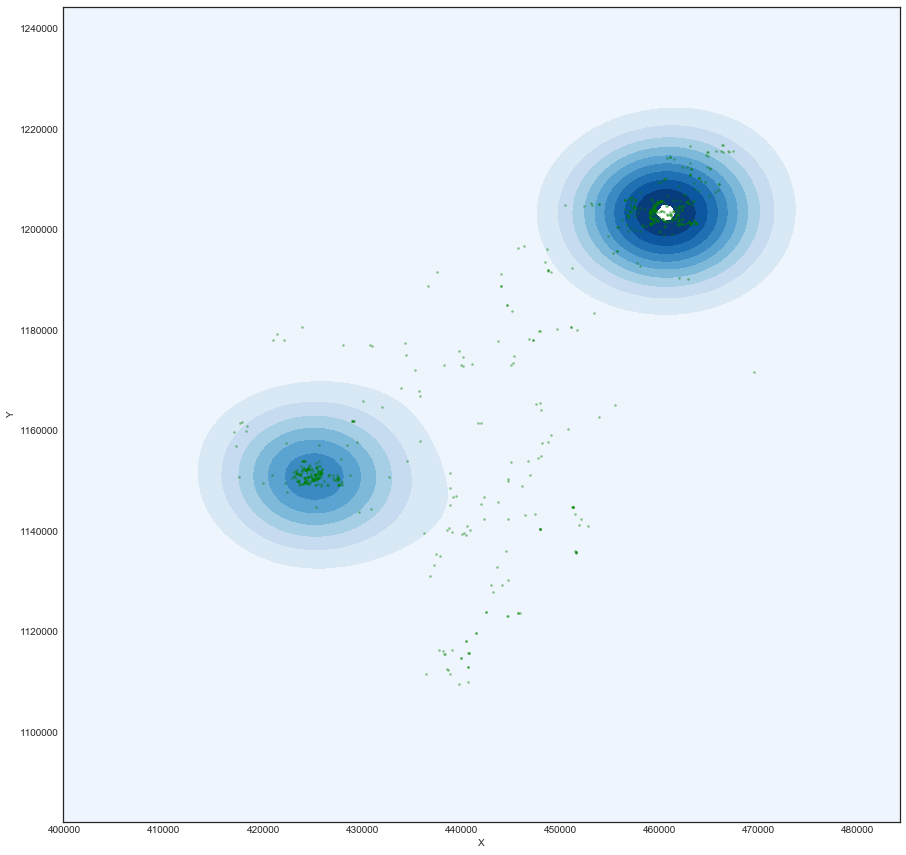

In [124]:
#Two dodgy points! They have significantly smaller x and y values. Let's get rid of them and replot.

canmore_shetland_modern_clean = canmore_shetland_modern[~canmore_shetland_modern['OBJECTID'].isin([99342,127836])]
fig, ax = plt.subplots(figsize=(15,15))

#modern site clusters will be in blue
sns.kdeplot(canmore_shetland_modern_clean['X'], canmore_shetland_modern_clean['Y'], shade=True, cmap='Blues');

#All the dated sites will appear as green dots, so we can see where the clusters are within the whole set of sites.
canmore_shetland_dated.plot(ax=ax, color='Green',markersize=3, alpha =0.3)
plt.show();


I'd say the modern sites are clustered in the same places as the prehistoric sites, with only the norse ones so far having a different distribution. But so far we have only been looking at the dated sites. Let's check the clustering of all the sites.

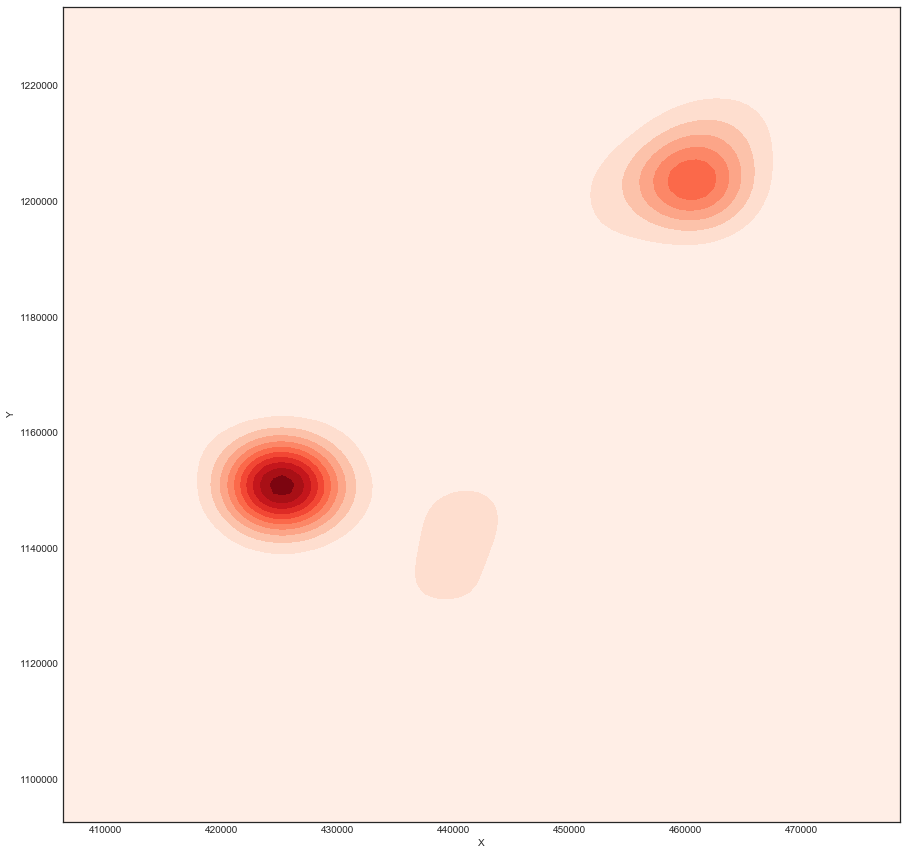

In [152]:
canmore_shetland_clean = canmore_shetland[~canmore_shetland['OBJECTID'].isin([99342,127836])]
fig, ax = plt.subplots(figsize=(15,15))
sns.kdeplot(canmore_shetland_clean['X'], canmore_shetland_clean['Y'], shade=True, cmap='Reds');

plt.show();


OK, after all that we are pretty convinced there are two areas that are dominating the pattern of sites we are seeing. Let's look inside the Norse clusters and explore further. WE can start by seeing what kinds of Norses sites have been identified.

In [140]:
norse = canmore_shetland_norse.groupby(['TYPE']).count()
norse

,CLASS,INFO,LINK,NOTES,OBJECTID,POLYCLAS,POLYTYPE,SOURCE,STATUS,X,Y,geometry
TYPE,,,,,,,,,,,,
"BUILDING (NORSE), MIDDEN (IRON AGE), STEATITE QUARRY (NORSE)",1,1,1,1,1,1,1,1,1,1,1,1
"BUILDING (PERIOD UNASSIGNED), ENCLOSURE (PERIOD UNASSIGNED), FARMSTEAD (NORSE)",1,1,1,1,1,1,1,1,1,1,1,1
"BUILDING (PERIOD UNASSIGNED), ENCLOSURE (PERIOD UNASSIGNED), FARMSTEAD (NORSE)(POSSIBLE)",1,1,1,1,1,1,1,1,1,1,1,1
"BUILDING (PERIOD UNASSIGNED), FARMSTEAD (NORSE)(POSSIBLE), MOUND (PERIOD UNASSIGNED)",1,1,1,1,1,1,1,1,1,1,1,1
"BUILDING(S) (PERIOD UNASSIGNED), FARMSTEAD (NORSE)",2,2,2,2,2,2,2,2,2,2,2,2
"CAIRN (PERIOD UNASSIGNED)(POSSIBLE), FARMSTEAD (NORSE), MOUND (PERIOD UNASSIGNED), STANDING STONE (PREHISTORIC)",1,1,1,1,1,1,1,1,1,1,1,1
"CLEARANCE CAIRN(S) (PERIOD UNASSIGNED), FARMSTEAD (PERIOD UNASSIGNED), FARMSTEAD (NORSE)(POSSIBLE), QUARRY (PERIOD UNASSIGNED), UNIDENTIFIED POTTERY (IRON AGE)",1,1,1,1,1,1,1,1,1,1,1,1
"ENCLOSURE(S) (PERIOD UNASSIGNED), FARMSTEAD (NORSE)(POSSIBLE), STRUCTURE(S) (PERIOD UNASSIGNED)",1,1,1,1,1,1,1,1,1,1,1,1
FARMSTEAD (NORSE),15,15,15,15,15,15,15,15,15,15,15,15


OK, so clearly there is *some* inconsistency in how site types have been named in Canmore. Let's grab everything that is a house, which seems a common category, and compare with farmsteads.

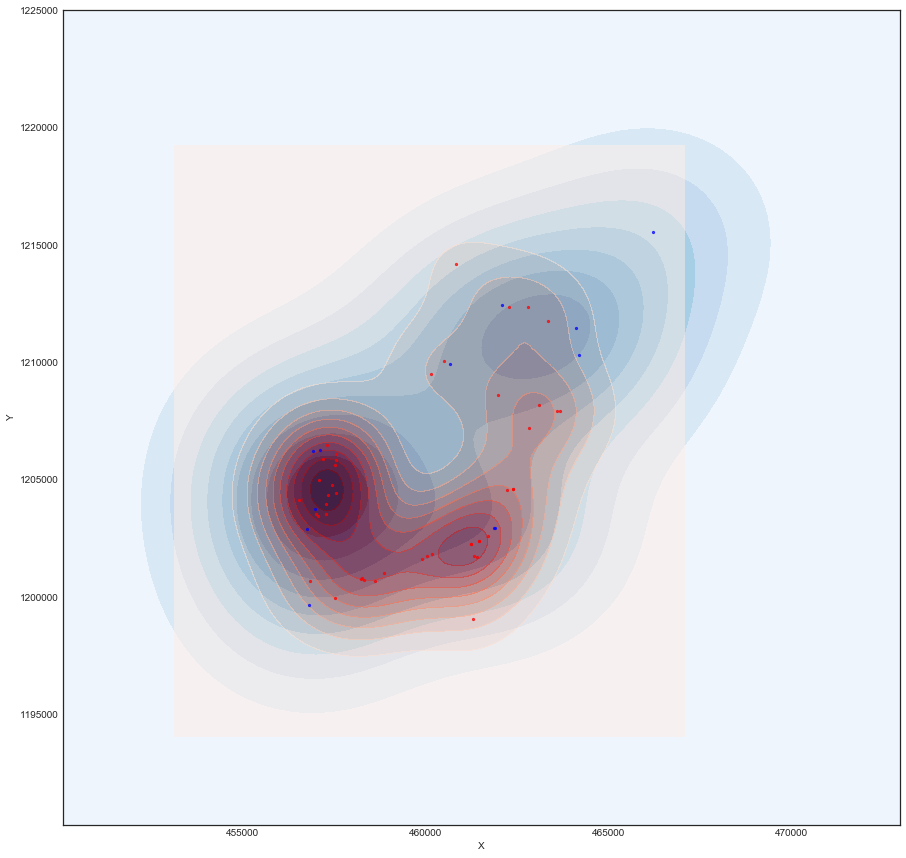

In [149]:
norse_houses = canmore_shetland_norse[canmore_shetland_norse['TYPE'].str.contains('HOUSE')]
norse_farms = canmore_shetland_norse[canmore_shetland_norse['TYPE'].str.contains('FARM')]

fig, ax = plt.subplots(figsize=(15,15))

sns.kdeplot(norse_houses['X'], norse_houses['Y'], shade=True, cmap='Blues');


sns.kdeplot(norse_farms['X'], norse_farms['Y'], shade=True, cmap='Reds', alpha=0.5);
norse_houses.plot(ax=ax, color='Blue',markersize=5, alpha =0.7);
norse_farms.plot(ax=ax, color='Red',markersize=5, alpha =0.7)
plt.show();


The patterns seem rather different, there is one shared cluster, but then we see variation... Do we expect to find houses and farms together? How might we explain the pattern we are seeing? Let's look at the types of sites found closest to farms. This is done through a 'nearest neighbour' calculation.

In [175]:
norse_otherf = canmore_shetland_norse[~canmore_shetland_norse['TYPE'].str.contains('FARM')]

In [167]:
pd.options.mode.chained_assignment = None  # default='warn'
neighbours = norse_otherf.geometry.unary_union
def near(point, pts=neighbours):
    # find the nearest point and return the corresponding Place value
    nearest = norse_otherf.geometry == nearest_points(point, pts)[1]
    return norse_otherf[nearest].TYPE.get_values()[0]
norse_farms['Nearest'] = norse_farms.apply(lambda row: near(row.geometry), axis=1)
norse_farms.sort_values('Nearest')

,CLASS,INFO,LINK,NOTES,OBJECTID,POLYCLAS,POLYTYPE,SOURCE,STATUS,TYPE,X,Y,geometry,Nearest
608,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/283386/,,99753,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Area of historic environment interest: This ar...,FARMSTEAD (NORSE)(POSSIBLE),457570.0,1205840.0,POINT (457568.1809048831 1205840.897715614),"FIELD SYSTEM (NORSE), HOUSE (NORSE)"
2318,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/283394/,,117724,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Area of historic environment interest: This ar...,FARMSTEAD(S) (NORSE)(POSSIBLE),457200.0,1205900.0,POINT (457196.0767667582 1205899.313588787),"FIELD SYSTEM (NORSE), HOUSE (NORSE)"
206,AGRICULTURE AND SUBSISTENCE,Historic Environment Scotland | Àrainneachd Ea...,https://canmore.org.uk/site/13/,,95067,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Some or all of this area is a Scheduled Monument,FARMSTEAD (NORSE),457520.0,1205610.0,POINT (457537.5479910522 1205630.342872791),"FIELD SYSTEM (NORSE), HOUSE (NORSE)"
2720,AGRICULTURE AND SUBSISTENCE,Historic Environment Scotland | Àrainneachd Ea...,https://canmore.org.uk/site/12/,,122171,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Some or all of this area is a Scheduled Monument,FARMSTEAD (NORSE),457570.0,1206110.0,POINT (457556.6571864869 1206119.347464688),"FIELD SYSTEM (NORSE), HOUSE (NORSE)"
559,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/283387/,,99173,DISCOVERY AREA,DISCOVERY,RCAHMS 10K record sheets (raster),Area of historic environment interest: This ar...,FARMSTEAD (NORSE)(POSSIBLE),457300.0,1206470.0,POINT (457299.9999999995 1206470),"FIELD SYSTEM (NORSE), HOUSE (NORSE)"
2173,"UNASSIGNED, AGRICULTURE AND SUBSISTENCE, MONUM...",Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/188722/,,116192,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Area of historic environment interest: This ar...,"BUILDING (PERIOD UNASSIGNED), ENCLOSURE (PERIO...",463340.0,1211760.0,POINT (463353.7198768744 1211768.001688677),"FIELD SYSTEM (PERIOD UNASSIGNED), HOUSE (NORSE..."
2546,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/283382/,,120251,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Area of historic environment interest: This ar...,FARMSTEAD (NORSE)(POSSIBLE),461970.0,1208550.0,POINT (461987.9496076217 1208601.426786772),HOUSE (NORSE)
3048,"AGRICULTURE AND SUBSISTENCE, DOMESTIC",Historic Environment Scotland | Àrainneachd Ea...,https://canmore.org.uk/site/49/,,125820,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Some or all of this area is a Scheduled Monument,"FARMSTEAD (NORSE), SETTLEMENT (PERIOD UNASSIGNED)",456830.0,1200700.0,POINT (456833.5883549144 1200698.802027283),HOUSE (NORSE)
2075,AGRICULTURE AND SUBSISTENCE,Archaeology: Shetland Amenity Trust,https://canmore.org.uk/site/283384/,,115404,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Area of historic environment interest: This ar...,FARMSTEAD (NORSE)(POSSIBLE),460500.0,1210050.0,POINT (460511.1002738494 1210052.982537172),HOUSE (NORSE)
2424,AGRICULTURE AND SUBSISTENCE,Historic Environment Scotland | Àrainneachd Ea...,https://canmore.org.uk/site/16/,,118794,KNOWN SITE EXTENT,FORM,25cm Orthorectified AP (raster),Some or all of this area is a Scheduled Monument,FARMSTEAD (NORSE),457080.0,1205010.0,POINT (457093.350619191 1205002.878553127),HOUSE (NORSE)


In [170]:
#Let's use the count function to see how many of each type of norse site appears near a norse farm.
norse_farms.groupby('Nearest').count()

,CLASS,INFO,LINK,NOTES,OBJECTID,POLYCLAS,POLYTYPE,SOURCE,STATUS,TYPE,X,Y,geometry
Nearest,,,,,,,,,,,,,
"FIELD SYSTEM (NORSE), HOUSE (NORSE)",5,5,5,5,5,5,5,5,5,5,5,5,5
"FIELD SYSTEM (PERIOD UNASSIGNED), HOUSE (NORSE), MOUND (PERIOD UNASSIGNED), SETTLEMENT (PERIOD UNASSIGNED), UNIDENTIFIED POTTERY (IRON AGE)",1,1,1,1,1,1,1,1,1,1,1,1,1
HOUSE (NORSE),25,25,25,25,25,25,25,25,25,25,25,25,25
"HOUSE (NORSE), STRUCTURE(S) (PERIOD UNASSIGNED)",3,3,3,3,3,3,3,3,3,3,3,3,3
HOUSE(S) (NORSE),8,8,8,8,8,8,8,8,8,8,8,8,8
SETTLEMENT (NORSE),4,4,4,4,4,4,4,4,4,4,4,4,4


### What do we conclude? 

### This ends the tutorial. You can practice exploring patterns in survey data further on your own.

Hopefully you learned to:
* learn to investigate patterns in archaeological survey data using spatial analytical tools
* learn to learn to make maps that illustrate patterns in archaeological survey data
* start thinking about the meaning of the patterns of sites and features in the landscape
